### PIL Module Introduction
#### version 1.0

This jupyter notebook introduction to the `PIL` module aims at explaining the __PIL detector__ class in the module, which enables one to quickly locate the potential Polarity Inversion Line (PIL) in a magnetic field image. Before looking into the 
following code blocks demonstrating the usage of the methods of the __PIL detector__ class, please run:
`%run PIL_module.ipynb` to import the PIL_module.

In [88]:
%run PIL_module.ipynb

### A Summary on the PIL module

For each image of the vertical component of the magnetic field, namely the image of "Bz", one wants to find the 
contour of Bz==0 that separates the strong positive magnetic polars and the associated strong negative polars, which 
is called the Polarity Inversion Line(PIL). Physicists are interested in the local magnetic field features around the PIL.

For a pixelized magnetic field image, there are several criteria that could help us filter the candidate pixels that could form a PIL:

 * The pixels on the PIL should be those pixels surrounded by both a __strong__ positive magnetic polar and a __strong__ negative magnetic polar.
 
 * The pixels on the PIL should be those pixels with large local vertical magnetic field gradient in its neighborhood.
 
 * The adjacent pixels on the same PIL should not be far away from each other in the image. Any points on the same PIL should be connected by other intermediate points. 
 

Based on these criteria, the PIL module provides some methods that combine these filtering operations altogether. By passing a magnetic field image into the methods, one is able to obtain the coordinates of all pixels that meet the above standards.  

The basic PIL detector class in the module is simply __PIL()__. So to create a PIL detector, one could simply write:

In [21]:
PIL_detector = PIL()

In [76]:
# full version of a well-specified PIL() looks like:
PIL_detector = PIL(edge_retain=0.003,polar_threshold=0.90,radius=12,min_samples=5,window_size=5)

There are basically 2 methods that can be called for this PIL_detector:

 * `.fit(image)`: a fit method that can detect the PILs in the input image.
 * `.visualize(image,savefigure=False,figname='HARP377')`: a visualization of the PILs detected together with the original input image.
 
And to find the PIL for a whole video in numpy-array or hdf5 format, one could simply call the function:

 * `PIL_fit_parallel(file,mode='image',core=8, filename='HARP377')`
 
But make sure multiprocessing is enabled on user's computer. Flux is certainly fine for running the __PIL_fit_parallel()__ function. Generally speaking, it takes less than __5 seconds__ for each image to be processed, and by setting the multiprocessing core to be 4, a file containing 1000 images shall be processed within __10 minutes__.

Before diving into the optional parameters in these functions. Firstly, the algorithm for finding the PIL will be explained in detail. For the convenience of demonstration, please load the image snippet `test_data.npy` which contains 10 high resolution vertical magnetic field image for HARP region 377 (AR 11158).

In [4]:
data = np.load('test_data.npy')
data[0]

array([[-3.9, -2.9, -0.7, ...,  4.3,  9. , 12. ],
       [-3. ,  0.1, -0.4, ...,  6.9,  7.4,  7.9],
       [ 0.5,  4. ,  2.3, ..., -2.3, -0.8,  3.7],
       ...,
       [-3.2, -2.9,  3. , ...,  4.5,  4.3,  2.1],
       [-5.3, -0.9,  2.1, ...,  3.4, -1. , -5.8],
       [-3.4, -2.1, -4.6, ...,  1.6,  2. ,  2.2]])

#### Step 1:  Image Decomposition and Pixel Ranking

For each image provided as an input for the `.fit()` method. There are pixels with positive values, negative values and NaN values. The first step is to split the image into a _positive component_ and a _negative component_. Where all NaN values are replaced by zero, the positive component of the image only contains all positive pixels, while all negative are replaced by zero. Likewise, the negative component only contains those negative pixels while all positive pixels are replaced by zero:

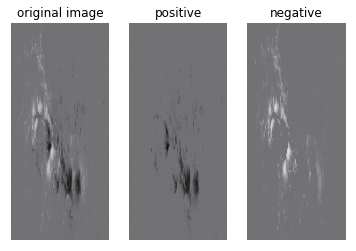

In [5]:
# the original image
image = data[0]

cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True) # use the grayscale color map
fig = plt.subplots(nrows=1, ncols=3)


for i, pair in enumerate([(image,'original image'),
                    (np.where(image>0,image,0),'positive'),
                   (np.where(image<0,image,0),'negative')]):
    ax = plt.subplot(1,3,i+1)
    sns.heatmap(pair[0],center=0, cmap=cmap,cbar=False,xticklabels=False, yticklabels=False, ax=ax)
    ax.title.set_text(pair[1])

And all positive pixels in the positive component image are ranked in __ascending order__. And in this rank, there is a parameter named `polar_threshold` in the instantiation of `PIL()`, ranges from 0 to 1, that specifies a percentage quantile in this ranked sequence, which is the threshold for determining whether a pixel is a "strong" positive pixel. If one sets `polar_threshold=0.90`, this means that the top 10% of all positive pixels are considerd as the "strong" positive pixels in this image. The same applies to the negative component.

#### Step 2: Image Maxpooling and Filtering

After setting the `polar_threshold`, one has a threshold for defining a strong positive pixel and a strong negative pixel. To meet the __first criterion__ we specified at the beginning, we need to find all pixels in the original image that has a strong positive pixel and a strong negative pixel __nearby__. The optional parameter `window_size` in `PIL()` defines the range of this "nearbyness". The default value of `window_size` is 5, which means that for each pixel in the image, find a 5\*5 subimage that contains the pixel of interest at its center. This subimage is the "neighborhood" of pixel. For example, in the following grayscale image, the point marked with a star has its 20\*20 neighborhood defined by the green square box.

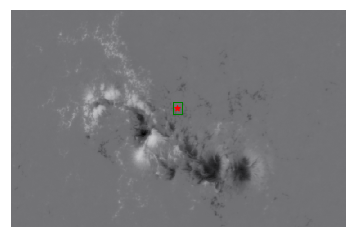

In [6]:
# A simple illustration of what it means as a neightborhood.
sns.heatmap(image,center=0, cmap=cmap,cbar=False,xticklabels=False, yticklabels=False)
plt.scatter(370,170,marker="*",c='red')
plt.plot([360, 360], [160, 180], 'k-', lw=1,c='green')
plt.plot([380, 380], [160, 180], 'k-', lw=1,c='green')
plt.plot([360, 380], [160, 160], 'k-', lw=1,c='green')
plt.plot([360, 380], [180,180], 'k-', lw=1,c='green')

Each image is zero-padded so each pixel has a complete neighborhood. Within each pixel's neighborhood, we search the largest and smallest Bz value, which can be considered as its local Bz maximum and local Bz minimum. If the local maximum of the pixel is a "strong" positive pixel as specified by `polar_threshold`, and the local minimum of the pixel is a "strong" negative pixel. Then this pixel is considered as a __potential PIL point__. For an image, call the `PIL.data_preparation(image)` would return an image with only the __potential PIL points__. It can be seen that the potential PIL points are one step closer to the final PIL points, but certainly a superset.

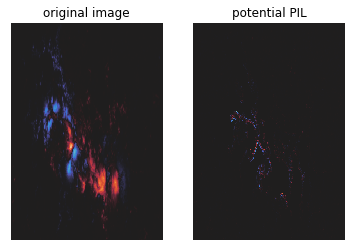

In [7]:
PIL_detector = PIL(window_size=5)
potential_PIL_point = PIL_detector.data_preparation(image)

# to visualize the potential PIL points: (color scale used to make the figure easily observable)
for i, pair in enumerate([(image,'original image'),
                    (potential_PIL_point,'potential PIL')]):
    ax = plt.subplot(1,2,i+1)
    sns.heatmap(pair[0],center=0, cbar=False,xticklabels=False, yticklabels=False, ax=ax)
    ax.title.set_text(pair[1])

#### Step 3: Edge Detection and Gradient Ranking

The next step is an operation on the potential PIL points. Basically the module is using the `scharr` edge detection operator in the `scikit.image` module. This operator is able to calculate each pixel's horizontal and vertical gradient, and return the norm of the gradient for each pixel. More on scharr edge detection maths and illustrations can be found in the "Alternative Operators" section on: https://en.wikipedia.org/wiki/Sobel_operator. To visualize what the operator is doing, see below:

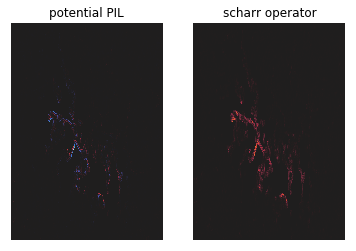

In [8]:
edge_detected = scharr(potential_PIL_point)

# to visualize the potential PIL points: (color scale used to make the figure easily observable)
for i, pair in enumerate([(potential_PIL_point,'potential PIL'),
                    (edge_detected,'scharr operator')]):
    ax = plt.subplot(1,2,i+1)
    sns.heatmap(pair[0],center=0, cbar=False,xticklabels=False, yticklabels=False, ax=ax)
    ax.title.set_text(pair[1])

We pass the image with only the potential points into the `scharr` operator and get each potential PIL point's gradient. Rank them in ascending order, and the parameter `edge_retain` in `PIL()`, ranges from 0 to 1, specifies what fraction out of all potential PIL points the user want to retain. The points ratained will be the points with the highest gradient norm. The default value will be 0.003, which means only 0.3% of all potential PIL points with the highest gradient norm will be retained. These points will almost be the final set of the PIL points. This edge detection step fulfils the second criterion above. See below for illustration.

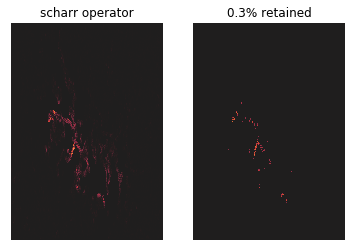

In [9]:
edge_retain = 0.003
gradient_threshold = np.percentile(edge_detected,q=(1-edge_retain)*100) # the gradient threshold

after_retain = np.where(edge_detected>gradient_threshold,edge_detected,0)

for i, pair in enumerate([(edge_detected,'scharr operator'),
                    (after_retain,'0.3% retained')]):
    ax = plt.subplot(1,2,i+1)
    sns.heatmap(pair[0],center=0, cbar=False,xticklabels=False, yticklabels=False, ax=ax)
    ax.title.set_text(pair[1])

#### Step 4: Pixels clustering

With a very limited set of points with both strong positive/negative polars in the neiborhood as well as a large gradient, we have generated a series of discrete points that can lie on the PIL. But discrete points do not necessarily guarantee that they can form a PIL. Perhaps an isolated noisy point could have mistakenly satisfy the first two criteria, but it is not very probable that these noisy points have a lot of neighbors that also satisfy the first two criteria. So we need to define how many points at least does a PIL should have, and how close these points shall be.

The parameter `radius` in `PIL()` instantiation exactly specifies the closeness any two points shall be if they are considered as points on the same PIL. The parameter `min_samples` in `PIL()`, on the other hand, specifies the least number of points a PIL should have. With these two parameters specified, we are indeed conducting a __Density-based spatial clustering of applications with noise (DBSCAN)__. To put it simply, DBSCAN is a clustering algorithm that can cluster points. Any cluster identified by DBSCAN should have at least one __core point__ that has at least K neighbor points within a radius R. Take the following figure as an example:

<img src="DBSCAN_figure.png" alt="Drawing" style="width: 200px;"/>

In this figure, all red points have at least K=4 neighbors within a circle with radius R=2. DBSCAN will thus consider one of the red points to start with, and all neighboring points within the core point's circle will be in the same cluster. Among all these neighboring points, if some of them are core points again, then all points within the circle of these neighboring core points will be attributed to the same cluster too. The step continues recursively until no further core points are found. All points found in these steps are clustered together. So for example point A is the point to start with, within 1 step or 2, all red points are found to be in the same cluster, and point B and C are _reachable_ from some of the red core points, so B and C are in the same cluster as A. But point N is not since it is not within any circle of any core point. And N itself is not a core point either, so N is identified as a __noisy point__ by DBSCAN. More details for DBSCAN can be found in https://en.wikipedia.org/wiki/DBSCAN

By the same token, for all points retained after edge detection, a DBSCAN with `K=min_samples` and `R=radius` is called to cluster all points into several __PIL segments__. By default, min_samples=5 and radius=12. So at 5 points are needed to form a PIL, and these points should be reachable from some core points with step size no longer than 12 pixels.

All in all, when a DBSCAN is applied, one is able to identify zero, one or multiple PIL segments. Each segment might contain hundreds or just several pixels. And for each PIL segment, the average gradient is calculated for all PIL points within the segment. All these information will be returned as the output for the `PIL.fit()` method. One can specify the parameter `select` in `.fit()` to select up to a certain amount of PIL segments to output. The segments with the largest average gradient is the first to be output. Default is 1, which means that only the PIL segment with the largest average gradient will be output.

In [67]:
# A complete code example for calling the fit() method:

data = np.load('test_data.npy')
image = data[0]
PIL_detector = PIL(polar_threshold=0.90,edge_retain=0.003,radius=12,min_samples=5,window_size=5)
result = PIL_detector.fit(image,select=1)

In [70]:
# to see the result:
PIL_segment = result[0] # if only 1 segment is returned, use result[0]. if N segments are returned, use result[k], k=0,...,N-1

# and to view the number of all points of the PIL segment
PIL_segment['coor'].shape # there are 322 points on this PIL

(322, 2)

In [72]:
# to view the average gradient of the PIL segment:
PIL_segment['weight']

283.91682928002825

### Find the PIL for all images of a Video

The `PIL().fit()` method is able to find several potential PIL segments in a single image. Now to locate PILs for all images of a video, besides running the `.fit()` over each image, one also need to compare these PIL segments across time, and drop the weaker PILs and retain the stronger PILs. Otherwise, each image might have at least 1 PIL. Some images in the early stage of the flare might have no PILs while some other images close to the flare eruption time or the sharp transition time may have multiple PILs.

To drop weak PILs, one need to specify a `global_threshold` parameter. To illustrate the meaning of this parameter, consider that each image now has 2 PIL segments founded, and one has 100 images in total. Setting `global_threshold=0.3` means that __drop 30% of all 200 PIL segments with the smallest average gradient.__

See code example below on how to fit PILs on a video with parallel computing:

In [ ]:
# a code example on fitting PIL on a video:
# RUN THIS ON FLUX !!!!

f = data # a video object, can be 3D array or an hdf5 file

PIL_fit_parallel(f,mode='image',core=8,global_threshold=0.3,edge_retain=0.003,polar_threshold=0.50,
                 radius=12,min_samples=5,select=1,window_size=5,filename='HARP377')

# will output a pickled dictionary if input is 3D array
# and after unpack the dictionary, for frame K in the video, one could use: dictionary[K] to view all PIL segments retained for the frame

# will output an hdf5 file with the same directory structure if input is hdf5
# for frame K in the video, one could use: file['video0']['frameK']['PIL'] for all PIL segments information (still a dictionary)


The `PIL()` class also provides a trivial way for fitting PIL on a video sequentially. See the section below for code example.

#### Image mode and Video mode

When instantiating a `PIL()` detector, there is one extra optional argument, `mode`, which has two potential values, `"image"` and `"video"`. The default is `"image"`, which means that the PIL detector will operate on a single image. Any strong positive and negative pixels are "strong" in the sense that they are relatively large in Bz magnitude __within the image__.

In the video mode, however, a pixel is considered as "strong" only if it is relatively large in terms of Bz magnitude __throughout the whole video provided__. Under video mode, the parameter `polar_threshold` defines the quantile of the sequence of all positive/negative Bz values in __the whole video__. 

If one uses the PIL detector for the video mode, one is enabling a polarity flux comparison across both the spatial and the temporal dimension. And this may help finding more PILs in an image where the HARP region is going through a phase of strong vertical magnetic flux, while fewer PILs in an image where the HARP region has weak vertical flux.

In [25]:
# Image mode example code I: fit PIL on a single image, then only image mode can be applied.

image = data[0]
result = PIL_detector.fit(image,select=1,mode="image")
result[0]['coor'].shape # there are in total more than 300 PIL points found on a single PIL segment

In [73]:
# Image mode example code II: fit PIL on a video, but just sequentially apply the same algorithm individually to each image

video = data
result_image = PIL_detector.fit(video,select=1,global_threshold=0.5,mode="image") # set global threshold = 0.5, so we deleta half of all PILs whose average gradient is relatively small

# this is the sequential implementation of the PIL detector

In [57]:
# Video mode example code: fit PIL on a video, but use a global threshold of strong positive and negative polar

video = data
result_video = PIL_detector.fit(video,select=1,global_threshold=0.5,mode="video")

In [62]:
# to see if the video mode and the image mode gives the same result on the PIL for the video, let us check how many points do
# each of the PIL segments that remain possesses:

# for image mode:
{p:result_image[p][0]['coor'].shape[0] for p in result_image if len(result_image[p])!=0}

{2: 324, 3: 313, 4: 309, 5: 320, 6: 75}

In [65]:
# for video mode:
{p:result_video[p][0]['coor'].shape[0] for p in result_video if len(result_video[p])!=0}
# they are roughly the same, but they have different interpretations. This is because the global strong polar threshold is slightly
# different from the strong polar threshold per image

{2: 322, 3: 313, 4: 308, 5: 320, 6: 75}

In [64]:
PIL_detector.__dict__

{'edge_retain': 0.003,
 'polar_threshold': 90.0,
 'radius': 12,
 'min_samples': 5,
 'window_size': 5,
 'DBSCAN': DBSCAN(algorithm='auto', eps=12, leaf_size=30, metric='euclidean',
     metric_params=None, min_samples=5, n_jobs=None, p=None),
 'PIL_segment': defaultdict(dict, {}),
 'PIL_segment_video': defaultdict(dict, {}),
 'pos_threshold': 195.0,
 'neg_threshold': 150.9,
 'pos_threshold_video': 190.3,
 'neg_threshold_video': 151.20000000000002,
 'invalid_image': False,
 'invalid_video': False,
 'global_mode': True,
 'N': 10}

### Visualize the detected polarity inversion line

Tuning the parameter of the `PIL()` class can be difficult sometimes. Since the algorithm is based on statistical approach instead of physical approach, user might need a more intuitive way to tune the parameters in the algorithm. The `.visualize()` method is such a tool to do this.

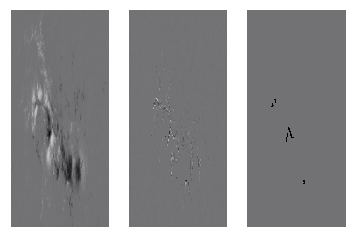

In [89]:
# .visualize() method code example

image = data[0]
PIL_detector = PIL(edge_retain=0.003,polar_threshold=0.90,radius=12,min_samples=5,window_size=5)

PIL_detector.visualize(image,select=3)

The `.visualize()` method displays three subplots in total. The left panel is the original image. The middle panel is the image with only the "strong" positive and negative pixels. And the right panel only contains the points of the polarity inversion line founded. In the example above, we select up to 3 polarity inversion lines, so in the right panel we see 3 clusters of points. If we reset the parameter to only select 1 polarity inversion line:

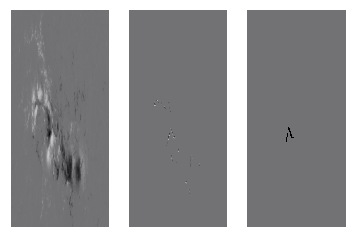

In [90]:
PIL_detector.visualize(image,select=1)

Then only the strongest one remains.